# Initialize

In [1]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

/home/albert/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-11-03 22:26:33.949687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730683594.379051  121182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730683594.521646  121182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 22:26:35.521389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is o

In [2]:
TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_size": (256, 256),
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 5,
}

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    image_size=CONFIG["im_size"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="categorical",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    image_size=CONFIG["im_size"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

Found 6799 files belonging to 3 classes.


I0000 00:00:1730683625.573969  121182 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2865 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Found 2278 files belonging to 3 classes.


# Lenet Model

2024-11-03 12:28:46.942913: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


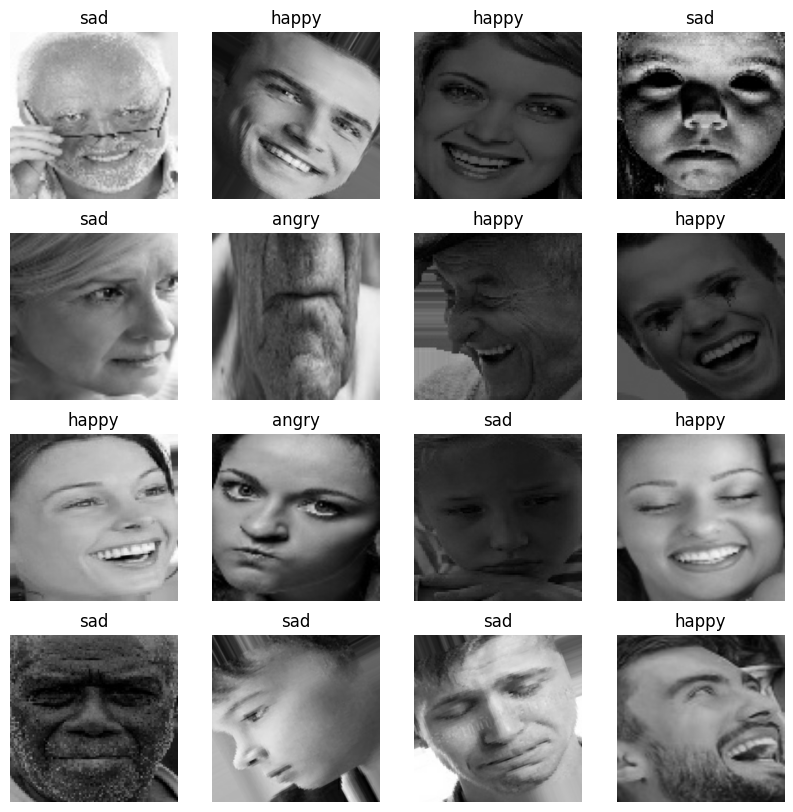

In [ ]:
plt.figure(figsize=[10, 10])

for images, labels in train_dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.0)
        plt.axis("off")
        plt.title(CLASS_NAMES[tf.math.argmax(labels[i])])

In [4]:
resize_rescale_layer = tf.keras.Sequential(
    [Resizing(*CONFIG["im_size"]), Rescaling(1.0 / 255.0)]
)

lenet_model = tf.keras.Sequential(
    [
        Input(shape=(CONFIG["input_shape"])),
        resize_rescale_layer,
        Conv2D(
            filters=CONFIG["filters_1"],
            kernel_size=CONFIG["kernel_size"],
            strides=CONFIG["strides_1"],
            padding="valid",
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=CONFIG["pool_size"], strides=CONFIG["strides_2"]),
        Dropout(rate=CONFIG["dropout"]),
        Conv2D(
            filters=CONFIG["filters_2"],
            kernel_size=CONFIG["kernel_size"],
            strides=CONFIG["strides_1"],
            padding="valid",
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        MaxPool2D(pool_size=CONFIG["pool_size"], strides=CONFIG["strides_2"]),
        Flatten(),
        Dense(
            CONFIG["dense_1"],
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        Dropout(rate=CONFIG["dropout"]),
        Dense(
            CONFIG["dense_2"],
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        Dropout(rate=CONFIG["dropout"]),
        Dense(
            CONFIG["dense_3"],
            activation=CONFIG["activation_1"],
            kernel_regularizer=L2(CONFIG["regularization_l2"]),
        ),
        BatchNormalization(),
        Dense(CONFIG["dense_out"], activation=CONFIG["activation_2"]),
    ]
)

lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIG["learning_rate"]),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=[CategoricalAccuracy(), TopKCategoricalAccuracy(k=2)],
)

lenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,968,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,971,891 (7.52 MB)

 Trainable params: 1,971,655 (7.52 MB)

 Non-trainable params: 236 (944.00 B)

In [5]:
history = lenet_model.fit(
    train_dataset, validation_data=test_dataset, epochs=CONFIG["epochs"], verbose=1
)

Epoch 1/5


I0000 00:00:1730683637.977027  121584 service.cc:148] XLA service 0x7f9b400084e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730683637.977129  121584 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-11-03 22:27:18.385789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730683638.992904  121584 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-03 22:27:22.727383: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_

212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.4490 - loss: 10.6097 - top_k_categorical_accuracy: 0.7507

2024-11-03 22:28:05.645922: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[15,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-03 22:28:06.128146: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[15,16,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,6,127,127]{3,2,1,0}, f32[16,6,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - categorical_accuracy: 0.4491 - loss: 10.5969 - top_k_categorical_accuracy: 0.7508

2024-11-03 22:28:19.583858: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,6,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[6,3,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-03 22:28:20.231970: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,16,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,6,127,127]{3,2,1,0}, f32[16,6,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn

213/213 ━━━━━━━━━━━━━━━━━━━━ 79s 265ms/step - categorical_accuracy: 0.4491 - loss: 10.5842 - top_k_categorical_accuracy: 0.7508 - val_categorical_accuracy: 0.3683 - val_loss: 3.4422 - val_top_k_categorical_accuracy: 0.7739
Epoch 2/5


2024-11-03 22:28:32.324924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categorical_accuracy: 0.4909 - loss: 3.0128 - top_k_categorical_accuracy: 0.7786

2024-11-03 22:29:00.019527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - categorical_accuracy: 0.4910 - loss: 3.0117 - top_k_categorical_accuracy: 0.7786 - val_categorical_accuracy: 0.4416 - val_loss: 2.5874 - val_top_k_categorical_accuracy: 0.7739
Epoch 3/5


2024-11-03 22:29:02.830098: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.5260 - loss: 2.1652 - top_k_categorical_accuracy: 0.8027

2024-11-03 22:29:30.435022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - categorical_accuracy: 0.5261 - loss: 2.1648 - top_k_categorical_accuracy: 0.8027 - val_categorical_accuracy: 0.3784 - val_loss: 1.8810 - val_top_k_categorical_accuracy: 0.7520
Epoch 4/5


2024-11-03 22:29:33.074690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_accuracy: 0.5290 - loss: 1.8086 - top_k_categorical_accuracy: 0.8085

2024-11-03 22:30:00.588840: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - categorical_accuracy: 0.5290 - loss: 1.8087 - top_k_categorical_accuracy: 0.8085 - val_categorical_accuracy: 0.5395 - val_loss: 1.9078 - val_top_k_categorical_accuracy: 0.8152
Epoch 5/5


2024-11-03 22:30:03.503420: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


213/213 ━━━━━━━━━━━━━━━━━━━━ 42s 198ms/step - categorical_accuracy: 0.5576 - loss: 1.8940 - top_k_categorical_accuracy: 0.8280 - val_categorical_accuracy: 0.5092 - val_loss: 2.3219 - val_top_k_categorical_accuracy: 0.8073


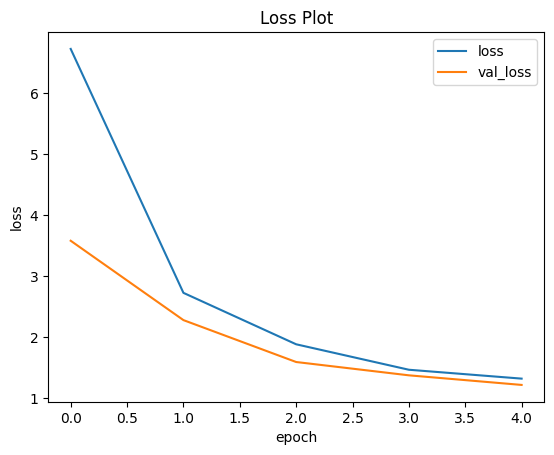

In [15]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title("Loss Plot")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

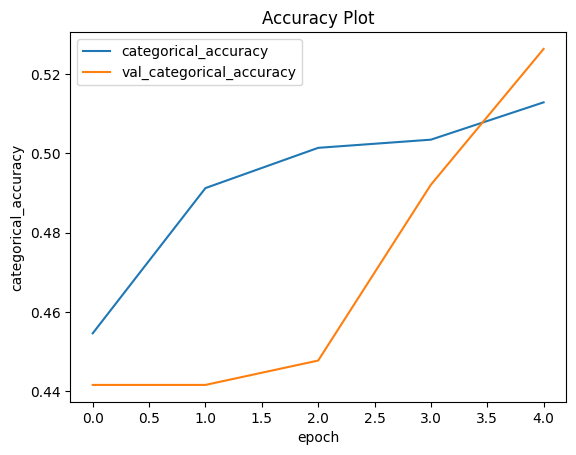

In [16]:
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.legend(["categorical_accuracy", "val_categorical_accuracy"])
plt.title("Accuracy Plot")
plt.xlabel("epoch")
plt.ylabel("categorical_accuracy")
plt.show()

2024-11-03 21:32:12.573284: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25166336 bytes after encountering the first element of size 25166336 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


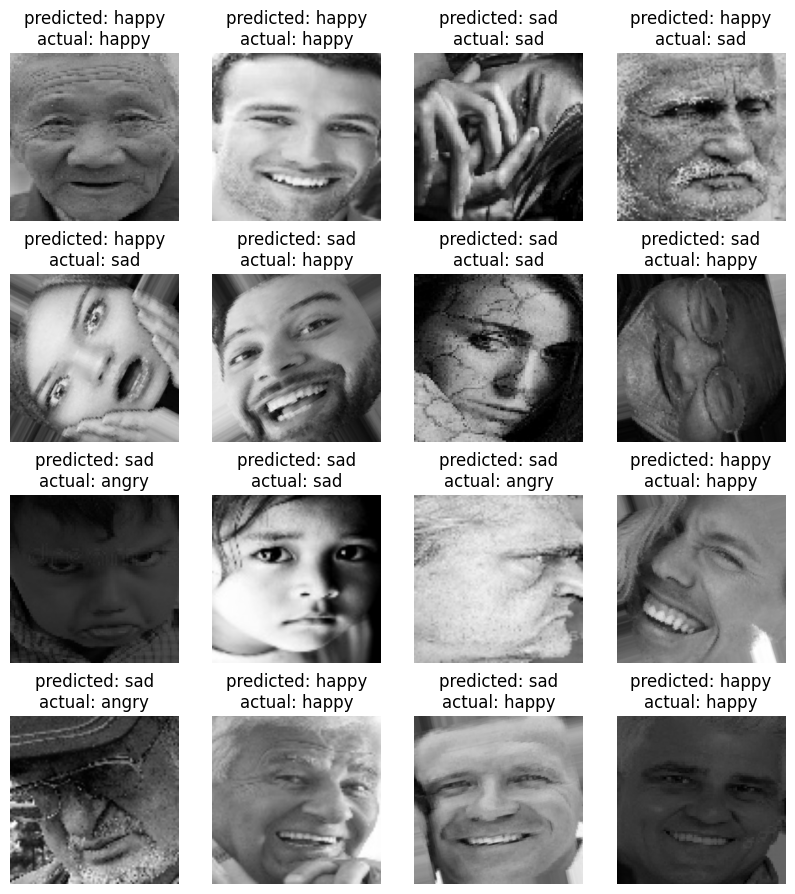

In [ ]:
plt.figure(figsize=[10, 11])

for images, labels in test_dataset.take(1):
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")
        plt.imshow(images[i] / 255.0)

        pred = lenet_model.predict(tf.expand_dims(images[i], axis=0), verbose=0)
        predicted = tf.math.argmax(pred, axis=-1)[0]
        actual = tf.math.argmax(labels[i], axis=0)
        # print(pred)
        # print(CLASS_NAMES[predicted], CLASS_NAMES[actual])
        
        plt.title(f"predicted: {CLASS_NAMES[predicted]}\nactual: {CLASS_NAMES[actual]}")

plt.show()

In [6]:
labels_true = []
predicted = []

for images, labels in test_dataset:
    predicted.append(tf.math.argmax(lenet_model.predict(images, verbose=0), axis=-1))
    labels_true.append(tf.math.argmax(labels, axis=-1))

print(len(labels_true))
print(len(predicted))

# We need to do this because the last batch not necessarely has 32 items.
# And because he doesn't have the same shape as the others, it cannot be feed
# directly to the confusion matrix.
labels_true = np.concatenate(
    [
        # Using tf.reshape to flatten.
        tf.reshape(labels_true[:-1], shape=[-1]),
        tf.reshape(labels_true[-1], shape=[-1]),  # last batch
    ]
)
predicted = np.concatenate(
    [
        tf.reshape(predicted[:-1], shape=[-1]),
        tf.reshape(predicted[-1], shape=[-1]),  # last batch
    ]
)

print(len(labels_true))
print(len(predicted))

2024-11-03 22:30:45.778696: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554944 bytes after encountering the first element of size 33554944 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


72
72
2278
2278


2024-11-03 22:30:59.139700: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


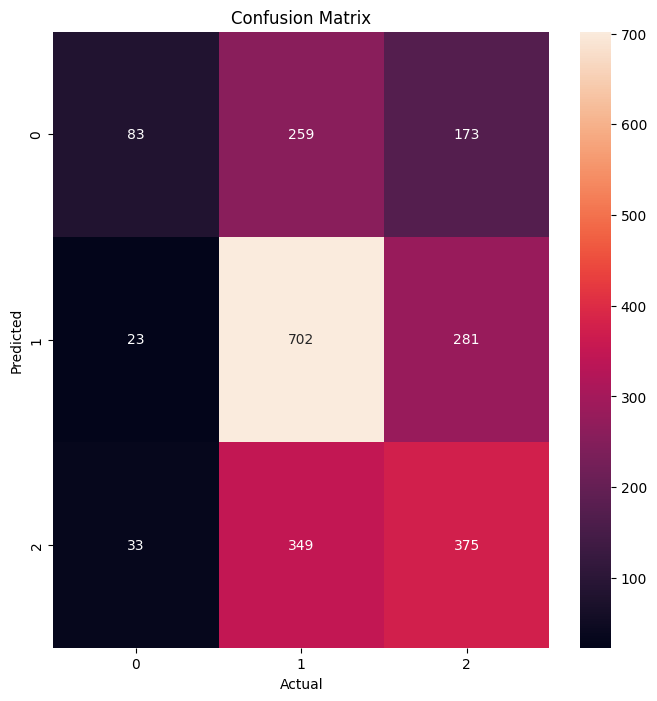

In [8]:
cm = confusion_matrix(labels_true, predicted)

plt.figure(figsize=[8, 8])
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()